In [1]:
import sys
sys.path.append('/mnt/local/data/vtrifonov/PNO')
from datasets.Elliptic import solvers

# from jax import config
# config.update('jax_enable_x64', True)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import equinox as eqx
import optax 

import jax
import jax.numpy as jnp
from jax.nn import relu
from jax import random, jit, lax
import jraph
from jax.experimental import sparse as jsparse

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import sys
from functools import partial
from itertools import chain

from data import dataset_LLT, direc_graph_from_linear_system_sparse, bi_direc_indx
# from train import TrainerLLT
from loss import LLT_loss

from model import MessagePassing, FullyConnectedNet, PrecNet
from train import train, compute_loss_LLT

In [6]:
grid = 4
N_samples = 1
A, b, u_exact, bi_edges, nodes, edges, receivers, senders = dataset_LLT(grid, N_samples, seed=42)

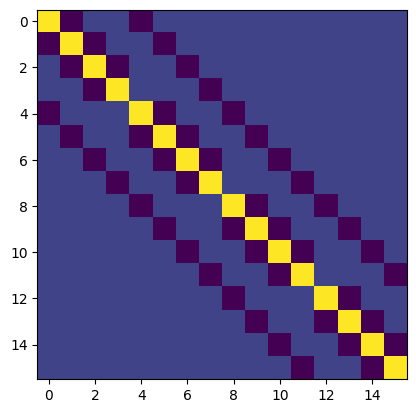

In [7]:
plt.imshow(A.todense()[0, ...])

In [53]:
(A.todense()[0, ...]).shape

(16, 16)

In [16]:
senders.shape

(1, 64)

In [52]:
nodes.shape

(1, 16)

In [74]:
check = jnp.nonzero(jnp.diff(jnp.hstack([senders[0, :, None], receivers[0, :, None]])), size=senders.shape[1]-nodes.shape[1], fill_value=jnp.nan)[0].astype(jnp.int32)
check_2 = jnp.where(jnp.diff(jnp.hstack([senders[0, :, None], receivers[0, :, None]])) == 0, 0, 1)
check_2 = jnp.squeeze(check_2).astype(bool)

In [75]:
check, check_2

(Array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 13, 14, 16, 17, 18, 19, 21, 22,
        23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 44,
        45, 46, 47, 49, 50, 52, 53, 54, 56, 57, 58, 60, 61, 62],      dtype=int32),
 Array([False,  True,  True,  True, False,  True,  True,  True, False,
         True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  True, False,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True,  True,
        False], dtype=bool))

In [76]:
check

Array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 13, 14, 16, 17, 18, 19, 21, 22,
       23, 24, 26, 27, 28, 29, 31, 32, 34, 35, 36, 37, 39, 40, 41, 42, 44,
       45, 46, 47, 49, 50, 52, 53, 54, 56, 57, 58, 60, 61, 62],      dtype=int32)

In [77]:
print(check.shape)
print(edges.shape)
print(edges[0, check].shape)
edges, edges[:, check]

(48,)
(1, 64)
(48,)


(Array([[ 6.25  , -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,
         -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,  6.25  , -1.5625,
         -1.5625,  6.25  , -1.5625, -1.5625, -1.5625, -1.5625,  6.25  ,
         -1.5625, -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,
         -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,  6.25  , -1.5625,
         -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,
         -1.5625,  6.25  , -1.5625, -1.5625, -1.5625, -1.5625,  6.25  ,
         -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,  6.25  ,
         -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,
          6.25  ]], dtype=float64),
 Array([[-1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625,
         -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625,
         -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625,
         -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625, -1.5625,
         -1.5625, -1.5625, -

In [50]:
print(check_2.shape)
print(edges.shape)
print(edges[0, check_2].shape)
display(edges.shape, edges[0, check_2].shape)
jnp.allclose(edges[:, check], edges[:, check_2])

(64,)
(1, 64)
(48,)


(1, 64)

(48,)

Array(True, dtype=bool)

In [5]:
A[0, ...].indices[:, 0]

Array([ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 12,
       12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15], dtype=int32)

In [6]:
import numpy as np
def bi_direc_indx(receivers, senders, n_node):
    '''Returns indices of edges which corresponds to bi-direcional connetions.'''
    r_s = jnp.hstack([receivers[..., None], senders[..., None]])
    s_r = jnp.hstack([senders[..., None], receivers[..., None]])

    nrows, ncols = r_s.shape
    dtype={'names': ['f{}'.format(i) for i in range(ncols)], 'formats': ncols * [r_s.dtype]}
    _, comm1, comm2 = np.intersect1d(np.array(r_s).view(dtype), np.array(s_r).view(dtype), return_indices=True)
    
    bi_edge_pairs = jnp.hstack([comm1[..., None], comm2[..., None]])
    bi_edge_pairs = np.unique(bi_edge_pairs.sort(axis=1), axis=0)
    non_duplicated_nodes = np.nonzero(np.diff(bi_edge_pairs, axis=1))[0]
    bi_edge_pairs = bi_edge_pairs[non_duplicated_nodes]
    return bi_edge_pairs

In [7]:
edges[0, ...].shape

(64,)

In [8]:
abc = bi_direc_indx(receivers[0, ...], senders[0, ...], nodes[1])

In [9]:
A[0, :, :].data

Array([ 6.25  , -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,
       -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,  6.25  , -1.5625,
       -1.5625,  6.25  , -1.5625, -1.5625, -1.5625, -1.5625,  6.25  ,
       -1.5625, -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,
       -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,  6.25  , -1.5625,
       -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,
       -1.5625,  6.25  , -1.5625, -1.5625, -1.5625, -1.5625,  6.25  ,
       -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,  6.25  ,
       -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,
        6.25  ], dtype=float64)

In [10]:
A[0, ...].data

Array([ 6.25  , -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,
       -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,  6.25  , -1.5625,
       -1.5625,  6.25  , -1.5625, -1.5625, -1.5625, -1.5625,  6.25  ,
       -1.5625, -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,
       -1.5625, -1.5625,  6.25  , -1.5625, -1.5625,  6.25  , -1.5625,
       -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,
       -1.5625,  6.25  , -1.5625, -1.5625, -1.5625, -1.5625,  6.25  ,
       -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,  6.25  ,
       -1.5625, -1.5625, -1.5625,  6.25  , -1.5625, -1.5625, -1.5625,
        6.25  ], dtype=float64)

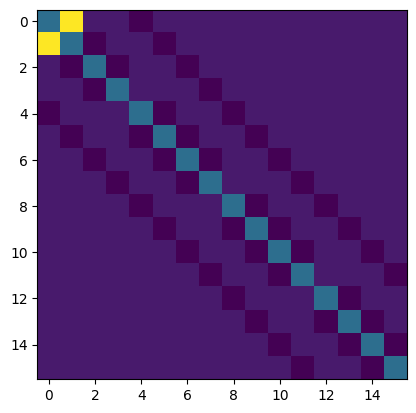

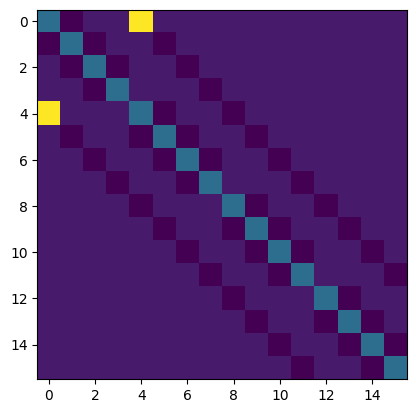

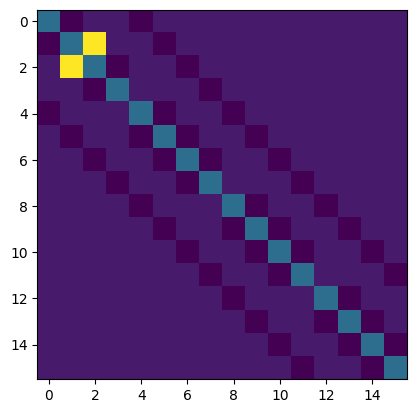

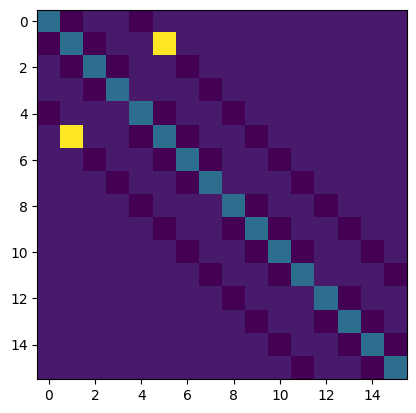

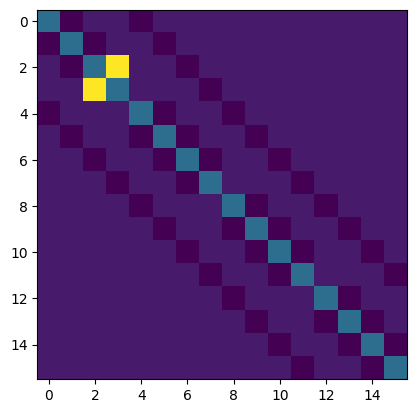

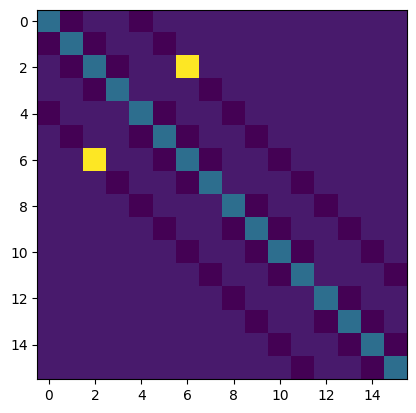

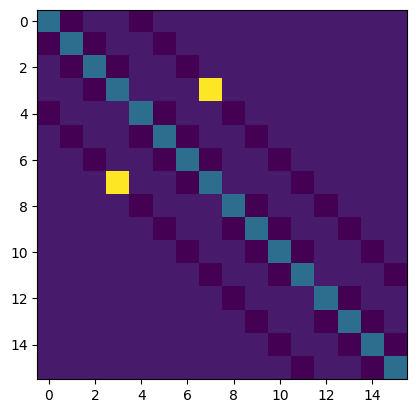

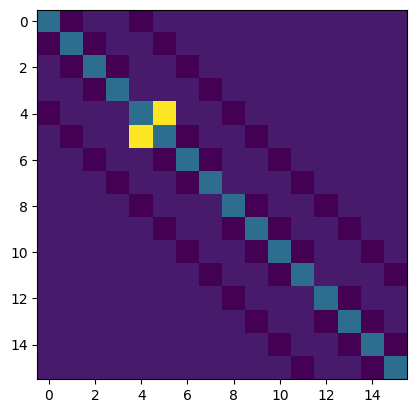

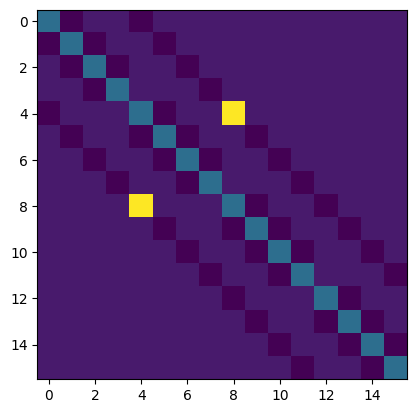

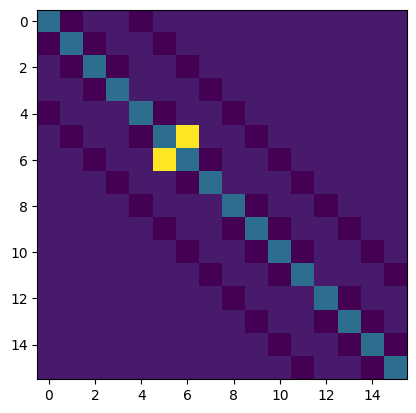

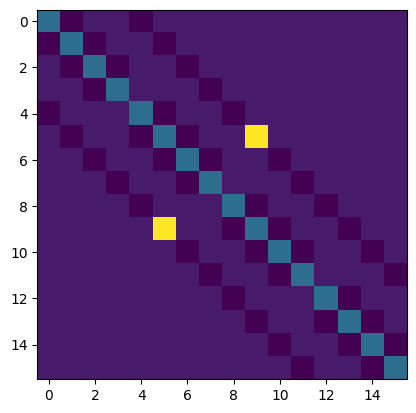

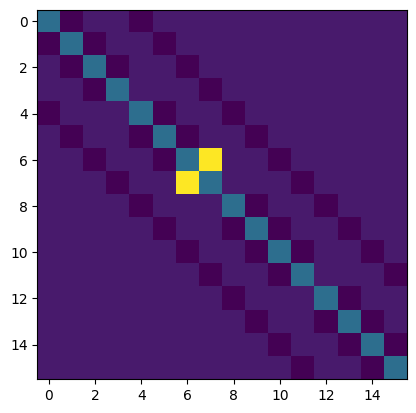

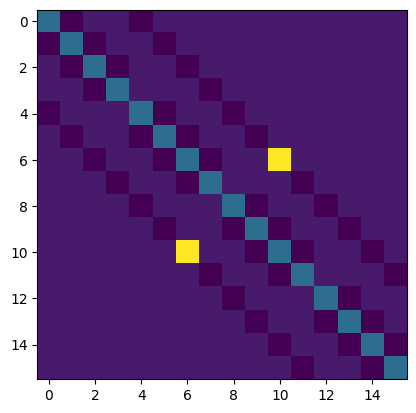

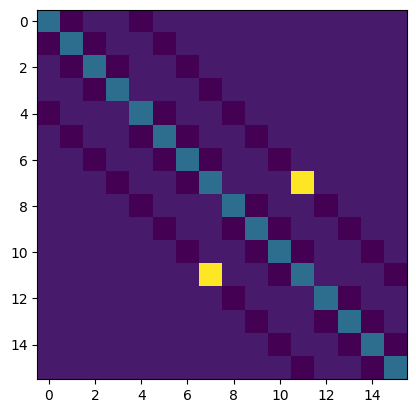

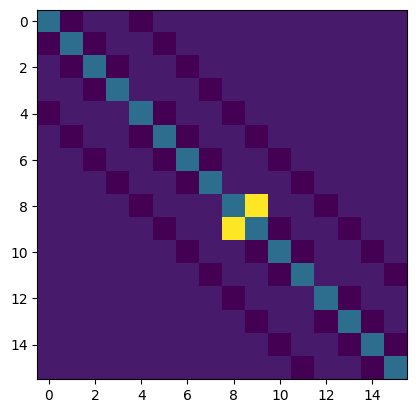

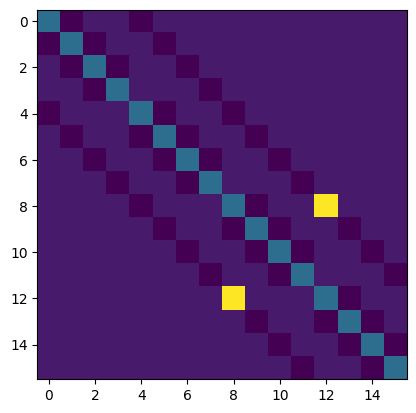

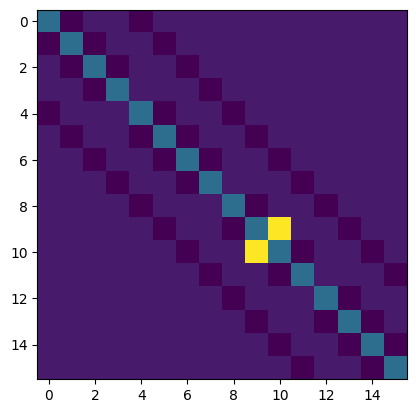

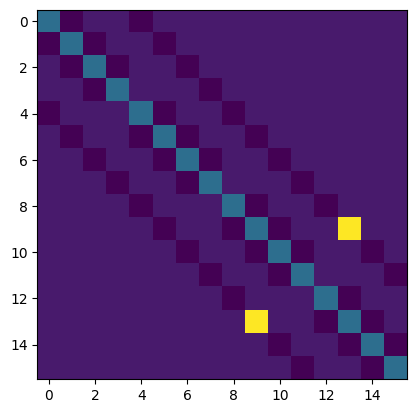

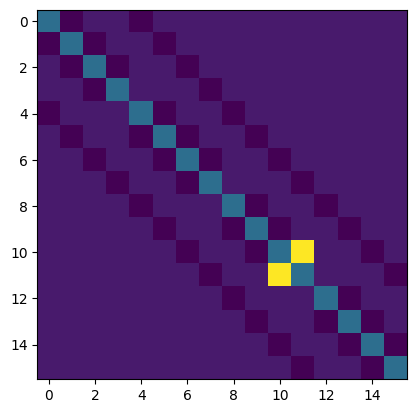

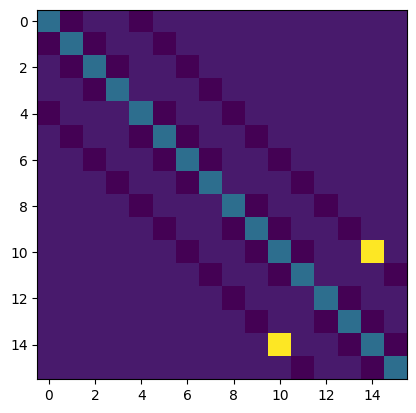

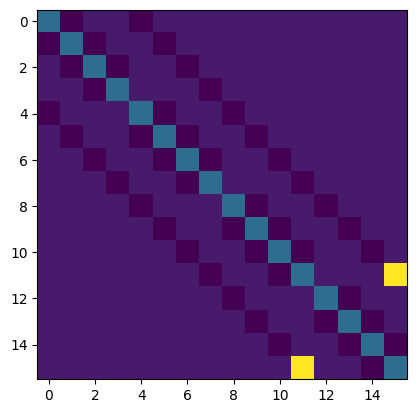

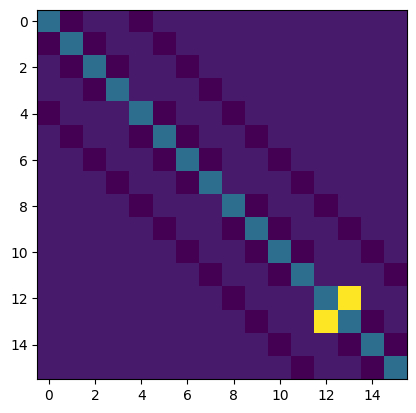

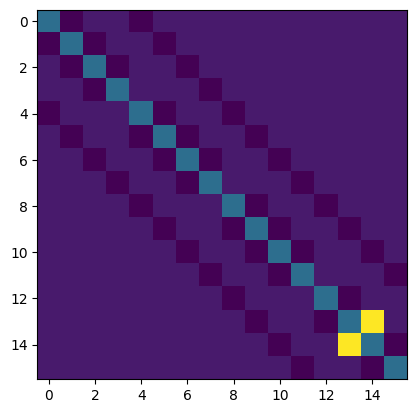

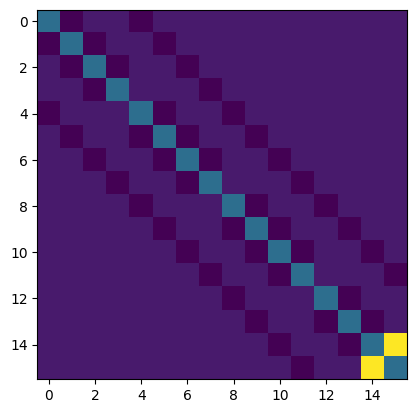

<Figure size 640x480 with 0 Axes>

In [11]:
i = 0 # [0, 23]
for i in range(24):
    edges_new = edges[0, ...].at[abc[i, :]].set(20)
    ABC = jsparse.BCOO((edges_new, A[0, ...].indices), shape=A[0, ...].shape)
    plt.imshow(ABC.todense())
    plt.show()
    plt.clf();

In [12]:
def bi_direc_edge_avg(edges, indices):
#     edges_upd = edges.copy()
#     for i in range(len(indices)):
#         edges_upd = edges_upd.at[indices[i]].set(jnp.mean(edges_upd[indices[i]]))
    b = len(edges)
    edges_new = edges[:, indices].mean(-1).reshape(b, -1, 1)
    edges_upd = edges.at[:, indices].set(edges_new)
    return edges_upd

In [13]:
egdes_new = jnp.arange(edges[0, ...].shape[0]*3).reshape(3, 64) * 4.
# egdes_new = jnp.ones_like(edges[0, ...])[None, :] / 1.
egdes_new

Array([[  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
        220., 224., 228., 232., 236., 240., 244., 248., 252.],
       [256., 260., 264., 268., 272., 276., 280., 284., 288., 292., 296.,
        300., 304., 308., 312., 316., 320., 324., 328., 332., 336., 340.,
        344., 348., 352., 356., 360., 364., 368., 372., 376., 380., 384.,
        388., 392., 396., 400., 404., 408., 412., 416., 420., 424., 428.,
        432., 436., 440., 444., 448., 452., 456., 460., 464., 468., 472.,
        476., 480., 484., 488., 492., 496., 500., 504., 508.],
       [512., 516., 520., 524., 528., 532., 536., 540., 544., 548., 552.,
        556., 560., 564., 568., 572., 576., 580., 584., 588.

In [14]:
bi_direc_edge_avg(egdes_new, bi_edges[0, ...])

Array([[  0.,   8.,  32.,   8.,  16.,  24.,  48.,  24.,  32.,  40.,  66.,
         40.,  48.,  82.,  32.,  60.,  70.,  98.,  48.,  70.,  80.,  90.,
        116.,  66.,  90., 100., 110., 136.,  82., 110., 120., 154.,  98.,
        132., 142., 170., 116., 142., 152., 162., 186., 136., 162., 172.,
        182., 204., 154., 182., 192., 220., 170., 204., 212., 186., 212.,
        220., 228., 204., 228., 236., 244., 220., 244., 252.],
       [256., 264., 288., 264., 272., 280., 304., 280., 288., 296., 322.,
        296., 304., 338., 288., 316., 326., 354., 304., 326., 336., 346.,
        372., 322., 346., 356., 366., 392., 338., 366., 376., 410., 354.,
        388., 398., 426., 372., 398., 408., 418., 442., 392., 418., 428.,
        438., 460., 410., 438., 448., 476., 426., 460., 468., 442., 468.,
        476., 484., 460., 484., 492., 500., 476., 500., 508.],
       [512., 520., 544., 520., 528., 536., 560., 536., 544., 552., 578.,
        552., 560., 594., 544., 572., 582., 610., 560., 582.

In [16]:
f = egdes_new.shape[0]
bi_ind_local = bi_edges[0, ...]
edges_local = egdes_new
edges_upd = edges_local[:, bi_ind_local].mean(-1).reshape(f, -1, 1)
edges_upd = edges_local.at[:, bi_ind_local].set(edges_upd)

# edges_new.shape, edges_local[:, bi_ind_local].shape
# jnp.vstack([egdes_new, edges_upd])
egdes_new, edges_upd

(Array([[  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
          44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
          88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
         132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
         176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
         220., 224., 228., 232., 236., 240., 244., 248., 252.],
        [256., 260., 264., 268., 272., 276., 280., 284., 288., 292., 296.,
         300., 304., 308., 312., 316., 320., 324., 328., 332., 336., 340.,
         344., 348., 352., 356., 360., 364., 368., 372., 376., 380., 384.,
         388., 392., 396., 400., 404., 408., 412., 416., 420., 424., 428.,
         432., 436., 440., 444., 448., 452., 456., 460., 464., 468., 472.,
         476., 480., 484., 488., 492., 496., 500., 504., 508.],
        [512., 516., 520., 524., 528., 532., 536., 540., 544., 548., 552.,
         556., 560., 564., 568., 572., 576., 58

In [17]:
edges_upd

Array([[  0.,   8.,  32.,   8.,  16.,  24.,  48.,  24.,  32.,  40.,  66.,
         40.,  48.,  82.,  32.,  60.,  70.,  98.,  48.,  70.,  80.,  90.,
        116.,  66.,  90., 100., 110., 136.,  82., 110., 120., 154.,  98.,
        132., 142., 170., 116., 142., 152., 162., 186., 136., 162., 172.,
        182., 204., 154., 182., 192., 220., 170., 204., 212., 186., 212.,
        220., 228., 204., 228., 236., 244., 220., 244., 252.],
       [256., 264., 288., 264., 272., 280., 304., 280., 288., 296., 322.,
        296., 304., 338., 288., 316., 326., 354., 304., 326., 336., 346.,
        372., 322., 346., 356., 366., 392., 338., 366., 376., 410., 354.,
        388., 398., 426., 372., 398., 408., 418., 442., 392., 418., 428.,
        438., 460., 410., 438., 448., 476., 426., 460., 468., 442., 468.,
        476., 484., 460., 484., 492., 500., 476., 500., 508.],
       [512., 520., 544., 520., 528., 536., 560., 536., 544., 552., 578.,
        552., 560., 594., 544., 572., 582., 610., 560., 582.

In [18]:
egdes_new

Array([[  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
         44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
         88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
        132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
        176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
        220., 224., 228., 232., 236., 240., 244., 248., 252.],
       [256., 260., 264., 268., 272., 276., 280., 284., 288., 292., 296.,
        300., 304., 308., 312., 316., 320., 324., 328., 332., 336., 340.,
        344., 348., 352., 356., 360., 364., 368., 372., 376., 380., 384.,
        388., 392., 396., 400., 404., 408., 412., 416., 420., 424., 428.,
        432., 436., 440., 444., 448., 452., 456., 460., 464., 468., 472.,
        476., 480., 484., 488., 492., 496., 500., 504., 508.],
       [512., 516., 520., 524., 528., 532., 536., 540., 544., 548., 552.,
        556., 560., 564., 568., 572., 576., 580., 584., 588.

In [19]:
display(egdes_new[:, 1])
display(edges_upd[:, 1])

Array([  4., 260., 516.], dtype=float64, weak_type=True)

Array([  8., 264., 520.], dtype=float64, weak_type=True)

In [20]:
for i in range(egdes_new.shape[-1]):
    print(egdes_new[:, i], edges_upd[:, i])

[  0. 256. 512.] [  0. 256. 512.]
[  4. 260. 516.] [  8. 264. 520.]
[  8. 264. 520.] [ 32. 288. 544.]
[ 12. 268. 524.] [  8. 264. 520.]
[ 16. 272. 528.] [ 16. 272. 528.]
[ 20. 276. 532.] [ 24. 280. 536.]
[ 24. 280. 536.] [ 48. 304. 560.]
[ 28. 284. 540.] [ 24. 280. 536.]
[ 32. 288. 544.] [ 32. 288. 544.]
[ 36. 292. 548.] [ 40. 296. 552.]
[ 40. 296. 552.] [ 66. 322. 578.]
[ 44. 300. 556.] [ 40. 296. 552.]
[ 48. 304. 560.] [ 48. 304. 560.]
[ 52. 308. 564.] [ 82. 338. 594.]
[ 56. 312. 568.] [ 32. 288. 544.]
[ 60. 316. 572.] [ 60. 316. 572.]
[ 64. 320. 576.] [ 70. 326. 582.]
[ 68. 324. 580.] [ 98. 354. 610.]
[ 72. 328. 584.] [ 48. 304. 560.]
[ 76. 332. 588.] [ 70. 326. 582.]
[ 80. 336. 592.] [ 80. 336. 592.]
[ 84. 340. 596.] [ 90. 346. 602.]
[ 88. 344. 600.] [116. 372. 628.]
[ 92. 348. 604.] [ 66. 322. 578.]
[ 96. 352. 608.] [ 90. 346. 602.]
[100. 356. 612.] [100. 356. 612.]
[104. 360. 616.] [110. 366. 622.]
[108. 364. 620.] [136. 392. 648.]
[112. 368. 624.] [ 82. 338. 594.]
[116. 372. 628

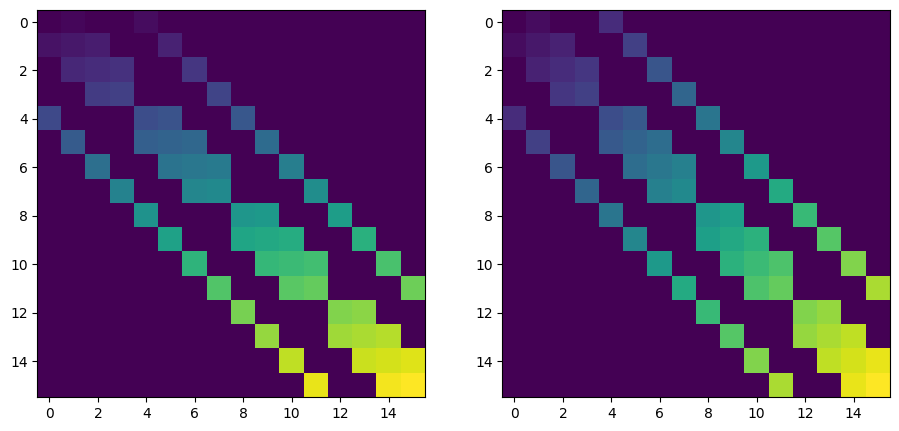

In [25]:
_, axes = plt.subplots(1, 2, figsize=(11, 11))

ABC_1 = jsparse.BCOO((egdes_new.squeeze()[0, ...], A[0, ...].indices), shape=A[0, ...].shape)
ABC_2 = jsparse.BCOO((edges_upd.squeeze()[0, ...], A[0, ...].indices), shape=A[0, ...].shape)

axes[0].imshow(ABC_1.todense())
axes[1].imshow(ABC_2.todense())
# plt.show()
# plt.clf();

In [29]:
jnp.allclose(ABC_2.todense(), ABC_2.todense().T)

Array(True, dtype=bool)

In [30]:
nodes.shape

(5, 16)

In [31]:
L = jnp.zeros([nodes.shape[1]]*2)
L = L.at[senders, receivers].set(edges)

In [34]:
A

BCOO(float64[5, 16, 16], nse=64, n_batch=1)

In [36]:
jnp.allclose(L, A[0, ...].todense())

Array(True, dtype=bool)

In [37]:
[1,2 ,3 ,4 , 5, 6][:-1]

[1, 2, 3, 4, 5]

In [38]:
[2]*2

[2, 2]

In [40]:
23300 ** (1/2)

152.64337522473747